<a href="https://colab.research.google.com/github/jenboland/DailyKnowledge/blob/master/Copy_of_MMM_quarterly_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install git+https://github.com/pymc-labs/pymc-marketing.git

  Cloning https://github.com/pymc-labs/pymc-marketing.git to /tmp/pip-req-build-zjpo6s74
  Running command git clone --filter=blob:none --quiet https://github.com/pymc-labs/pymc-marketing.git /tmp/pip-req-build-zjpo6s74
  Resolved https://github.com/pymc-labs/pymc-marketing.git to commit 06d1a34d5c03df7891c14dc4d333ed2668f9fc3a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 4.3 MB/s eta 0:00:00
  Created wheel for pymc-marketing: filename=pymc_marketing-0.12.0-py3-none-any.whl size=253874 sha256=ef66a84ec206afe2a749f506219075a049c7977452d9817cfaa326d103f5a2a3
  Stored in directory: /tmp/pip-ephem-wheel-cache-4chp1h3i/wheels/74/4e/df/061764542e2335eb91488d930c91f3e06058325d53a008deb7
Successfully built pymc-marketing


In [3]:
!pip install numpyro


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.8/365.8 kB 9.0 MB/s eta 0:00:00


In [4]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import numpyro

from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation, MichaelisMentenSaturation
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"


In [5]:
import pymc_marketing
print(pymc_marketing.__version__)

0.12.0


In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
path_ = "/content/drive/MyDrive/Colab Notebooks/"

In [189]:
df_daily = pd.read_csv(
    path_ + "cafb_donations_thru_2024.csv",
    parse_dates=["Date"],
    index_col=["Date"]
)

df_daily.index = pd.to_datetime(df_daily.index)

df_daily["iso_week"] = df_daily.index.isocalendar().week
df_daily["iso_year"] = df_daily.index.isocalendar().year

#print(df_daily.loc["2024-12-01":"2024-12-05"])


# Create columns week_43..week_52
for w in range(43, 53):
    col = f"week_{w}"
    df_daily[col] = 0.0
    mask = df_daily["iso_week"] == w
    df_daily.loc[mask, col] = 1.0

df_daily["giving_tuesday"] = 0.0
df_daily["end_of_year"] = 0.0

# Mark giving_tuesday day(s)
giving_tuesday_dates = [
    pd.Timestamp('2022-11-29'),
    pd.Timestamp('2023-11-28'),
    pd.Timestamp('2024-12-03'),
]
df_daily.loc[df_daily.index.isin(giving_tuesday_dates), "giving_tuesday"] = 1.0
df_daily["giving_tuesday"] = df_daily["giving_tuesday"].astype(float)


# Zero out the corresponding week column for those single days
for dt in giving_tuesday_dates:
    iso_wk = df_daily.loc[dt, "iso_week"]  # e.g. 49
    col = f"week_{iso_wk}"
    df_daily.loc[dt, col] = 0.0

# Mark end_of_year
mask_eoy = (df_daily.index.month == 12) & (df_daily.index.day == 31)
df_daily.loc[mask_eoy, "end_of_year"] = 1.0

# Zero out the corresponding week column for those EOY days
df_daily.loc[mask_eoy, "week_52"] = 0.0  # if EOY is in iso week 52
# or do the same approach with .loc for the iso_week

df_dummies = df_daily.resample("W").max()

# Now you have columns ["week_43","week_44",..., "week_52","giving_tuesday","end_of_year"] in df_weekly
#print(df_dummies[["giving_tuesday","week_49"]].loc["2024-12-01":"2024-12-10"])


In [190]:
# prompt: drop revenue from df_dummies

# Assuming 'Revenue' is the column name you want to drop.
# If it's different, replace 'Revenue' with the actual column name.
if 'Revenue' in df_dummies.columns:
    df_dummies = df_dummies.drop(columns=['Revenue'])


In [191]:
#bing = pd.read_csv(path_+'cafb_bing_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()  #not updated, not in model

#dm = pd.read_csv(path_+'cafb_direct_mail_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum() combined dm, not longer used in model

dm_acq = pd.read_csv(path_+'dm_acquisition.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
dm_appeals = pd.read_csv(path_+'dm_appeal.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()

sales = pd.read_csv(path_+'cafb_donations_thru_2024.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()


email = pd.read_csv(path_+'cafb_email_20241231.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum() #updated

fb = pd.read_csv(path_+'cafb_meta_20241231.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum() #updated

#paid_search = pd.read_csv(path_+'cafb_google_paid_search.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum() #not in model

prog = pd.read_csv(path_+'cafb_programmatic_20250205.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum() #updated

ftf = pd.read_csv(path_+'cafb_ftf_20241231.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum() #updated


#ga4 = pd.read_csv(path_+'cafb_ga4_sessions.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum() #not in model



In [192]:
# prompt: in df prog, I'd like to divide Programatic_Impressions by 2 since we know that half impression are to bots. this needs to be a safe divide because some weeks have 0 impressions

# Divide Programatic_Impressions by 2 safely
prog['Programatic_Impressions'] = prog['Programatic_Impressions'].div(2, fill_value=0)


In [193]:
df = pd.concat([dm_acq, dm_appeals, email, fb, prog, ftf ,sales, df_dummies], axis=1).fillna(0).head(158).reset_index()  #figure out how many rows to keep to get all of 2024
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

df.head()

,Date,DM_Acq_Impressions,DM_Acq_Spend,DM_Appeal_Impressions,DM_Appeal_Spend,Email_Impressions,Email_Spend,FB_Spend,FB_Impressions,Programatic_Impressions,...,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52,giving_tuesday,end_of_year
0,2022-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2022-01-09,0.0,0.0,0.0,0.0,60000.0,1000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-01-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-01-23,0.0,0.0,0.0,0.0,111374.0,1000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-01-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [194]:
df["november"] = df["Date"].apply(lambda x: 1 if x.month in [11] else 0)
df["december"] = df["Date"].apply(lambda x: 1 if x.month in [12] else 0)

#df['trend'] = df['Revenue'].shift(1).fillna(method="bfill")
#fix trend
#df['trend'] = df['Consumer_Demand']


In [195]:
df_ = df.set_index('Date')
input_df = df_[['Revenue', *[c for c in df_.columns if 'Impressions' in c], "week_43","week_44","week_45","week_46","week_47","week_48",  "week_49","week_50","week_51","week_52","giving_tuesday","end_of_year", "november", 'december']]
#spend_df = df_[['Revenue', *[c for c in df_.columns if 'Spend' in c], "week_43","week_44","week_45","week_46","week_47","week_48",  "week_49","week_50","week_51","week_52","giving_tuesday","end_of_year", "november", 'december']]

In [196]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)


#df = spend_df.copy()
df = input_df.copy()
df = df.reset_index()

n = df.shape[0]
print(f"Number of observations: {n}")

Number of observations: 158


In [197]:
data = df.copy()
X = data.drop("Revenue", axis=1)
y = data["Revenue"]

In [198]:
from pymc_marketing.prior import Prior
import pymc_marketing.mmm as mmm

In [199]:
ch = [ 'DM_Appeal_Impressions', 'DM_Acq_Impressions', 'Email_Impressions',
       'FB_Impressions',  'Programatic_Impressions',
       'FTF_Impressions']

controls = ['end_of_year', 'november', 'december']


In [200]:
custom_config = {
    "intercept": {
        "dist": "HalfNormal",
        "kwargs": {"sigma": 5}
    },
    # saturation_beta: vectorized Gamma priors for each channel.
    # Channel order: ['DM_Appeal_Spend', 'DM_Acq_Spend', 'Email_Spend', 'FB_Spend', 'Programatic_Spend', 'FTF_Spend']
    # For DM_Appeal_Spend, we set alpha=14, beta=2, so mean = 14/2 = 7.0.
    # For DM_Acq_Spend, we set alpha=8, beta=20, so mean = 8/20 = 0.4.
    # For the other channels, we use a generic prior (mean = 2/2 = 1.0).
    "saturation_beta": {
        "dist": "Gamma",
        "kwargs": {
            "alpha": [14, 2, 2, 2, 2, 14],
            "beta":  [2, 5, 2, 4, 12, 2],
        },
        "dims": "channel",
    },
    # saturation_lam: here we also supply vectorized Gamma priors.
    # For instance, you might set DM_Appeal_Spend with mean 2/4 = 0.5,
    # DM_Acq_Spend with mean 2/5 = 0.4, and the others at 2/4 = 0.5.
    "saturation_lam": {
        "dist": "Gamma",
        "kwargs": {
            "alpha": [2, 2, 2, 2, 2, 2],
            "beta":  [4, 5, 4, 6, 12, 4],
        },
        "dims": "channel",
    },
    "gamma_control": {
        "dist": "HalfNormal",
        "kwargs": {"sigma": 2.5}
    },
    "gamma_fourier": {
        "dist": "Laplace",
        "kwargs": {"mu": 0, "b": 2}
    },
    "media_tvp_config": {
         "m": 5,
         "L": 30,
         "eta_lam": 2,
         "ls_mu": 2,
         "ls_sigma": 5,
         "cov_func": None
    },
}




media_tvp_config = {
    "media_tvp_config": {
        "m": 5,  # Reduced number of basis functions from 50
        "L": 30,  # Reduced from 30
        "eta_lam": 2,  # Increased from 2 for stronger smoothing
        "ls_mu": 2,  # Reduced from 2
        "ls_sigma": 5,  # Reduced from 5
        "cov_func": None, #"exponential"  # Added covariance function for better regularization
    }
}

custom_config = {**custom_config, **media_tvp_config}


In [201]:
all_features = ['Date'] + ch + controls
X = df[all_features].copy()



# 3) Subset df to these columns for modeling
X = df[all_features].copy()
y = df["Revenue"].copy()

In [202]:
mmm = MMM(
    model_config=custom_config,
    sampler_config={"progressbar": True},
    date_column="Date",
    adstock=GeometricAdstock(l_max=8),
    saturation=MichaelisMentenSaturation(),
    channel_columns=ch,
    control_columns=controls,
    yearly_seasonality=1, # 1 oer 2
    time_varying_media=True,
    time_varying_intercept=False
)


In [203]:
mmm.fit(X=X, y=y, nuts_sampler="numpyro",target_accept=0.95, chains=4, draws=6_000, random_seed=rng)

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

# Full Model Results

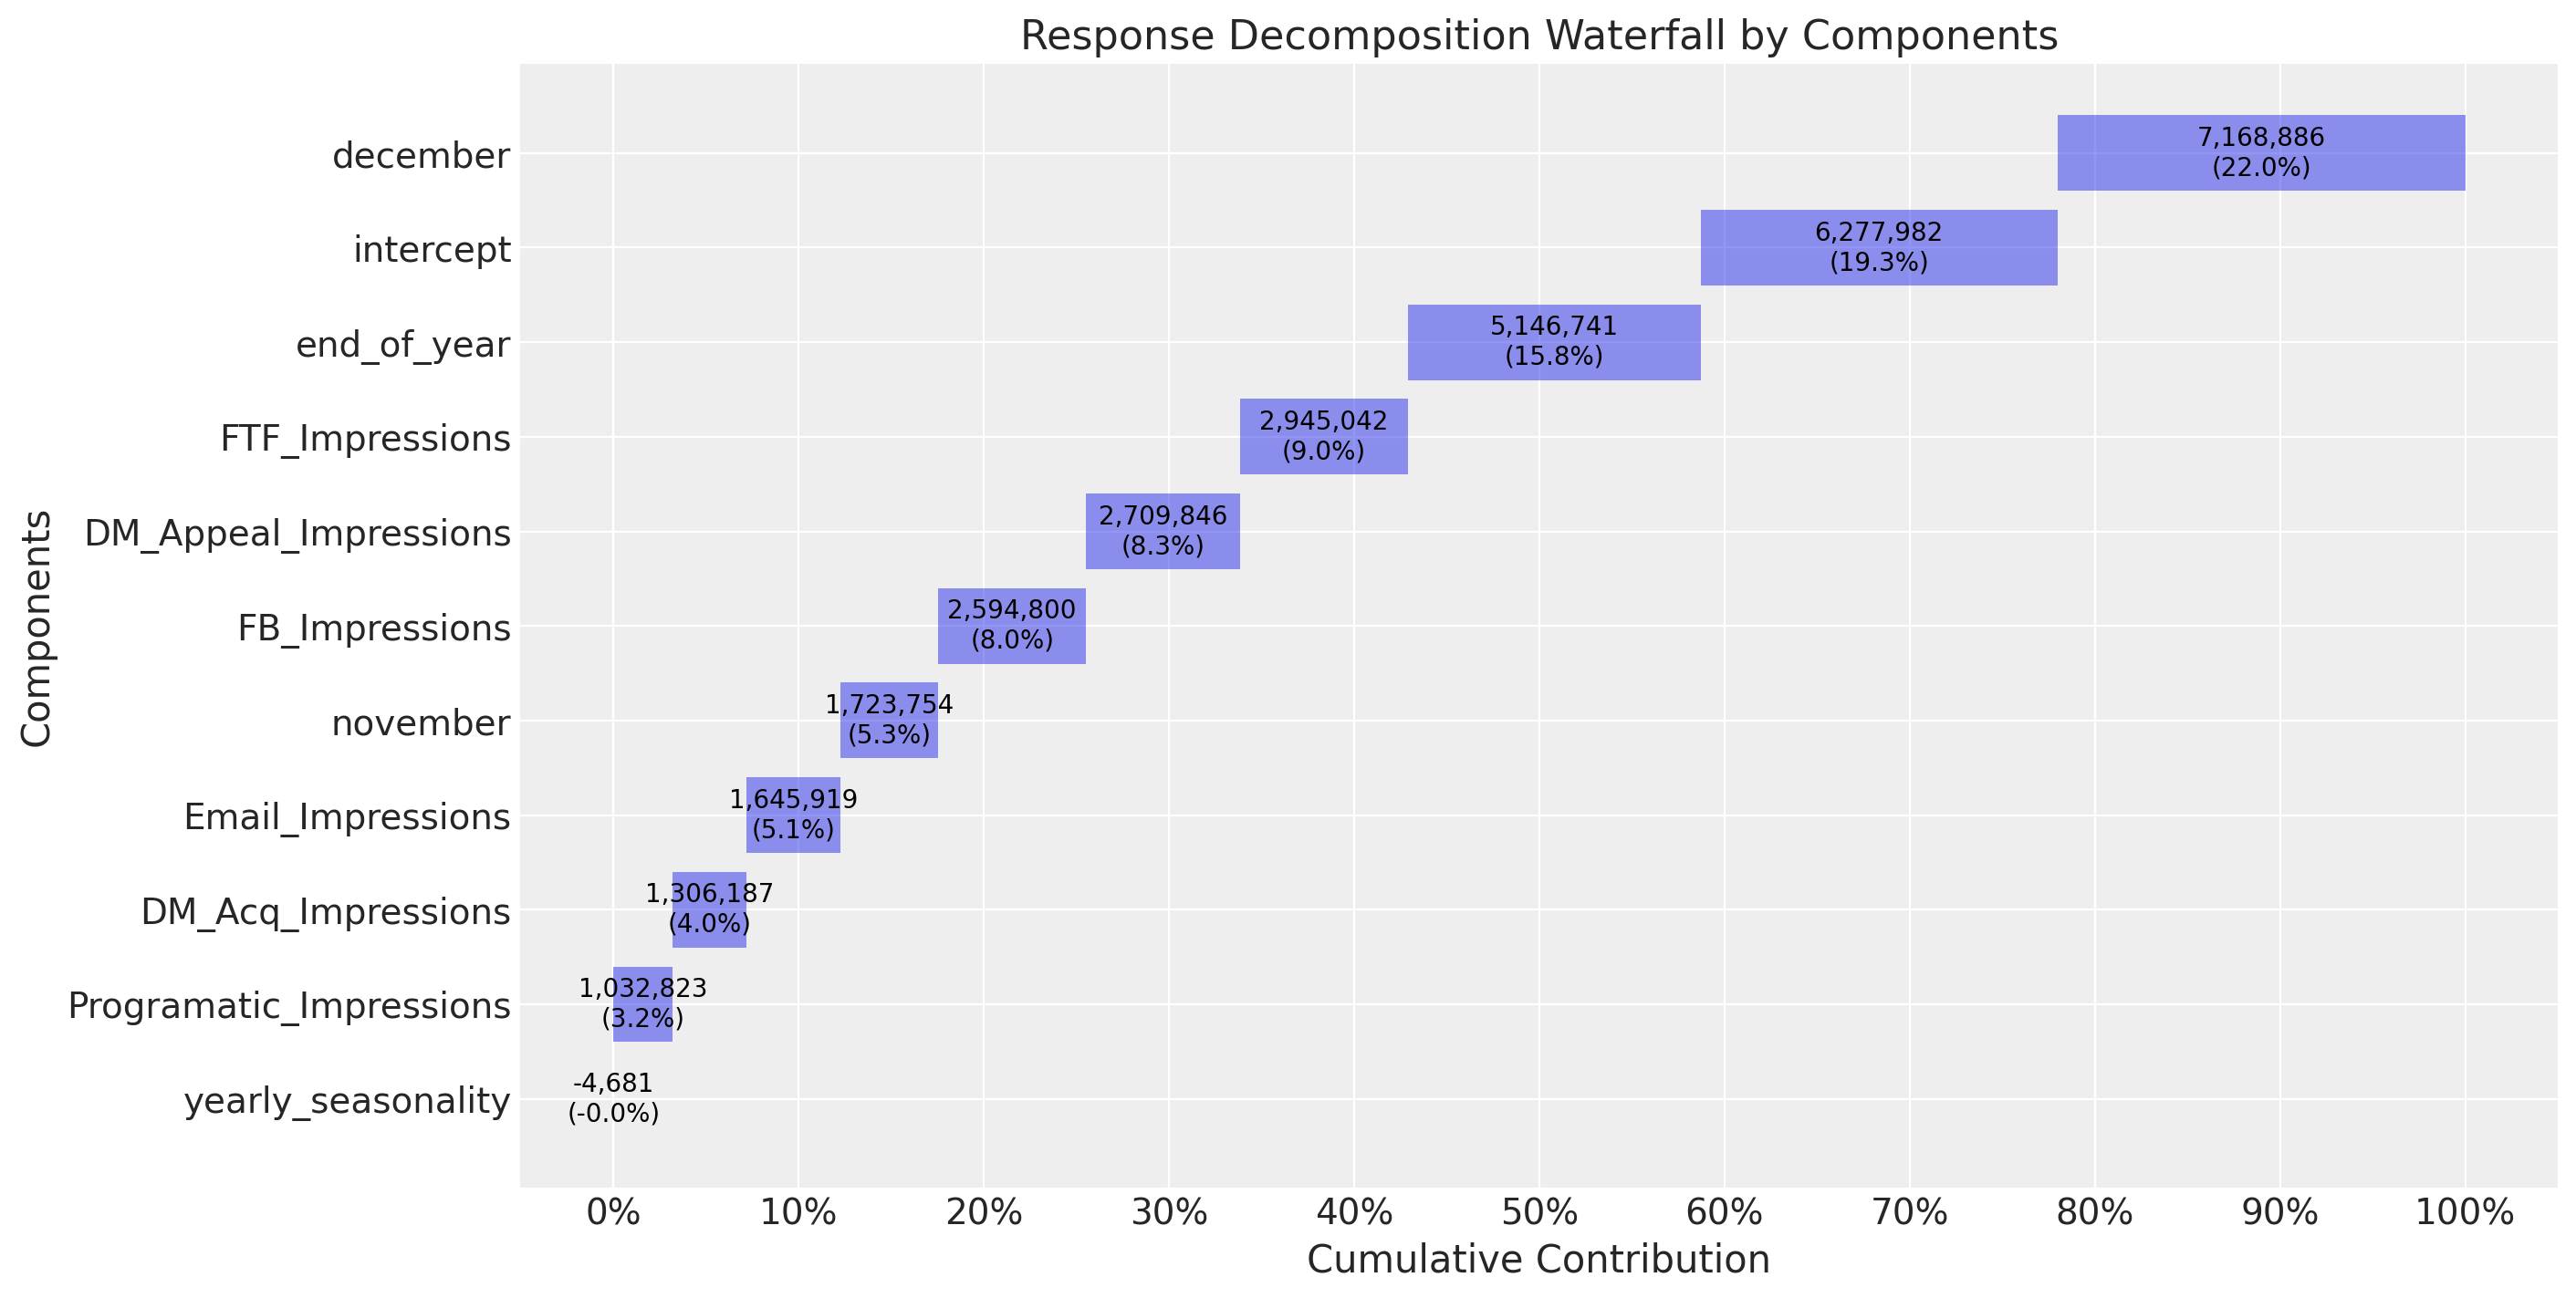

In [204]:
mmm.plot_waterfall_components_decomposition();

In [205]:
#use these functions for raw revenue
from sklearn.metrics import r2_score

def get_mape(mmm_):
    y_pred = mmm_.predict(X)  # Use the original X DataFrame with datetime 'Date'
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    print(f"MAPE: {mape}")

def get_r2(mmm_):
    y_pred = mmm_.predict(X)  # Use the original X DataFrame with datetime 'Date'
    r2 = r2_score(y, y_pred)
    return r2

print(get_mape(mmm))
print(get_r2(mmm))


Output()

MAPE: 29.777141364066384
None


Output()

0.9608279959786018


In [206]:
X.head(104)

,Date,DM_Appeal_Impressions,DM_Acq_Impressions,Email_Impressions,FB_Impressions,Programatic_Impressions,FTF_Impressions,end_of_year,november,december
0,2022-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,2022-01-09,0.0,0.0,60000.0,0.0,0.0,6487.0,0.0,0,0
2,2022-01-16,0.0,0.0,0.0,0.0,0.0,10886.0,0.0,0,0
3,2022-01-23,0.0,0.0,111374.0,0.0,0.0,1378.0,0.0,0,0
4,2022-01-30,0.0,0.0,0.0,0.0,0.0,3511.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...
99,2023-11-26,43704.0,0.0,158450.0,46505.0,175731.5,0.0,0.0,1,0
100,2023-12-03,0.0,0.0,459208.0,48840.0,100120.0,0.0,0.0,0,1
101,2023-12-10,0.0,0.0,0.0,52670.0,16211.0,0.0,0.0,0,1
102,2023-12-17,50781.0,37735.0,0.0,51700.0,20597.5,0.0,0.0,0,1


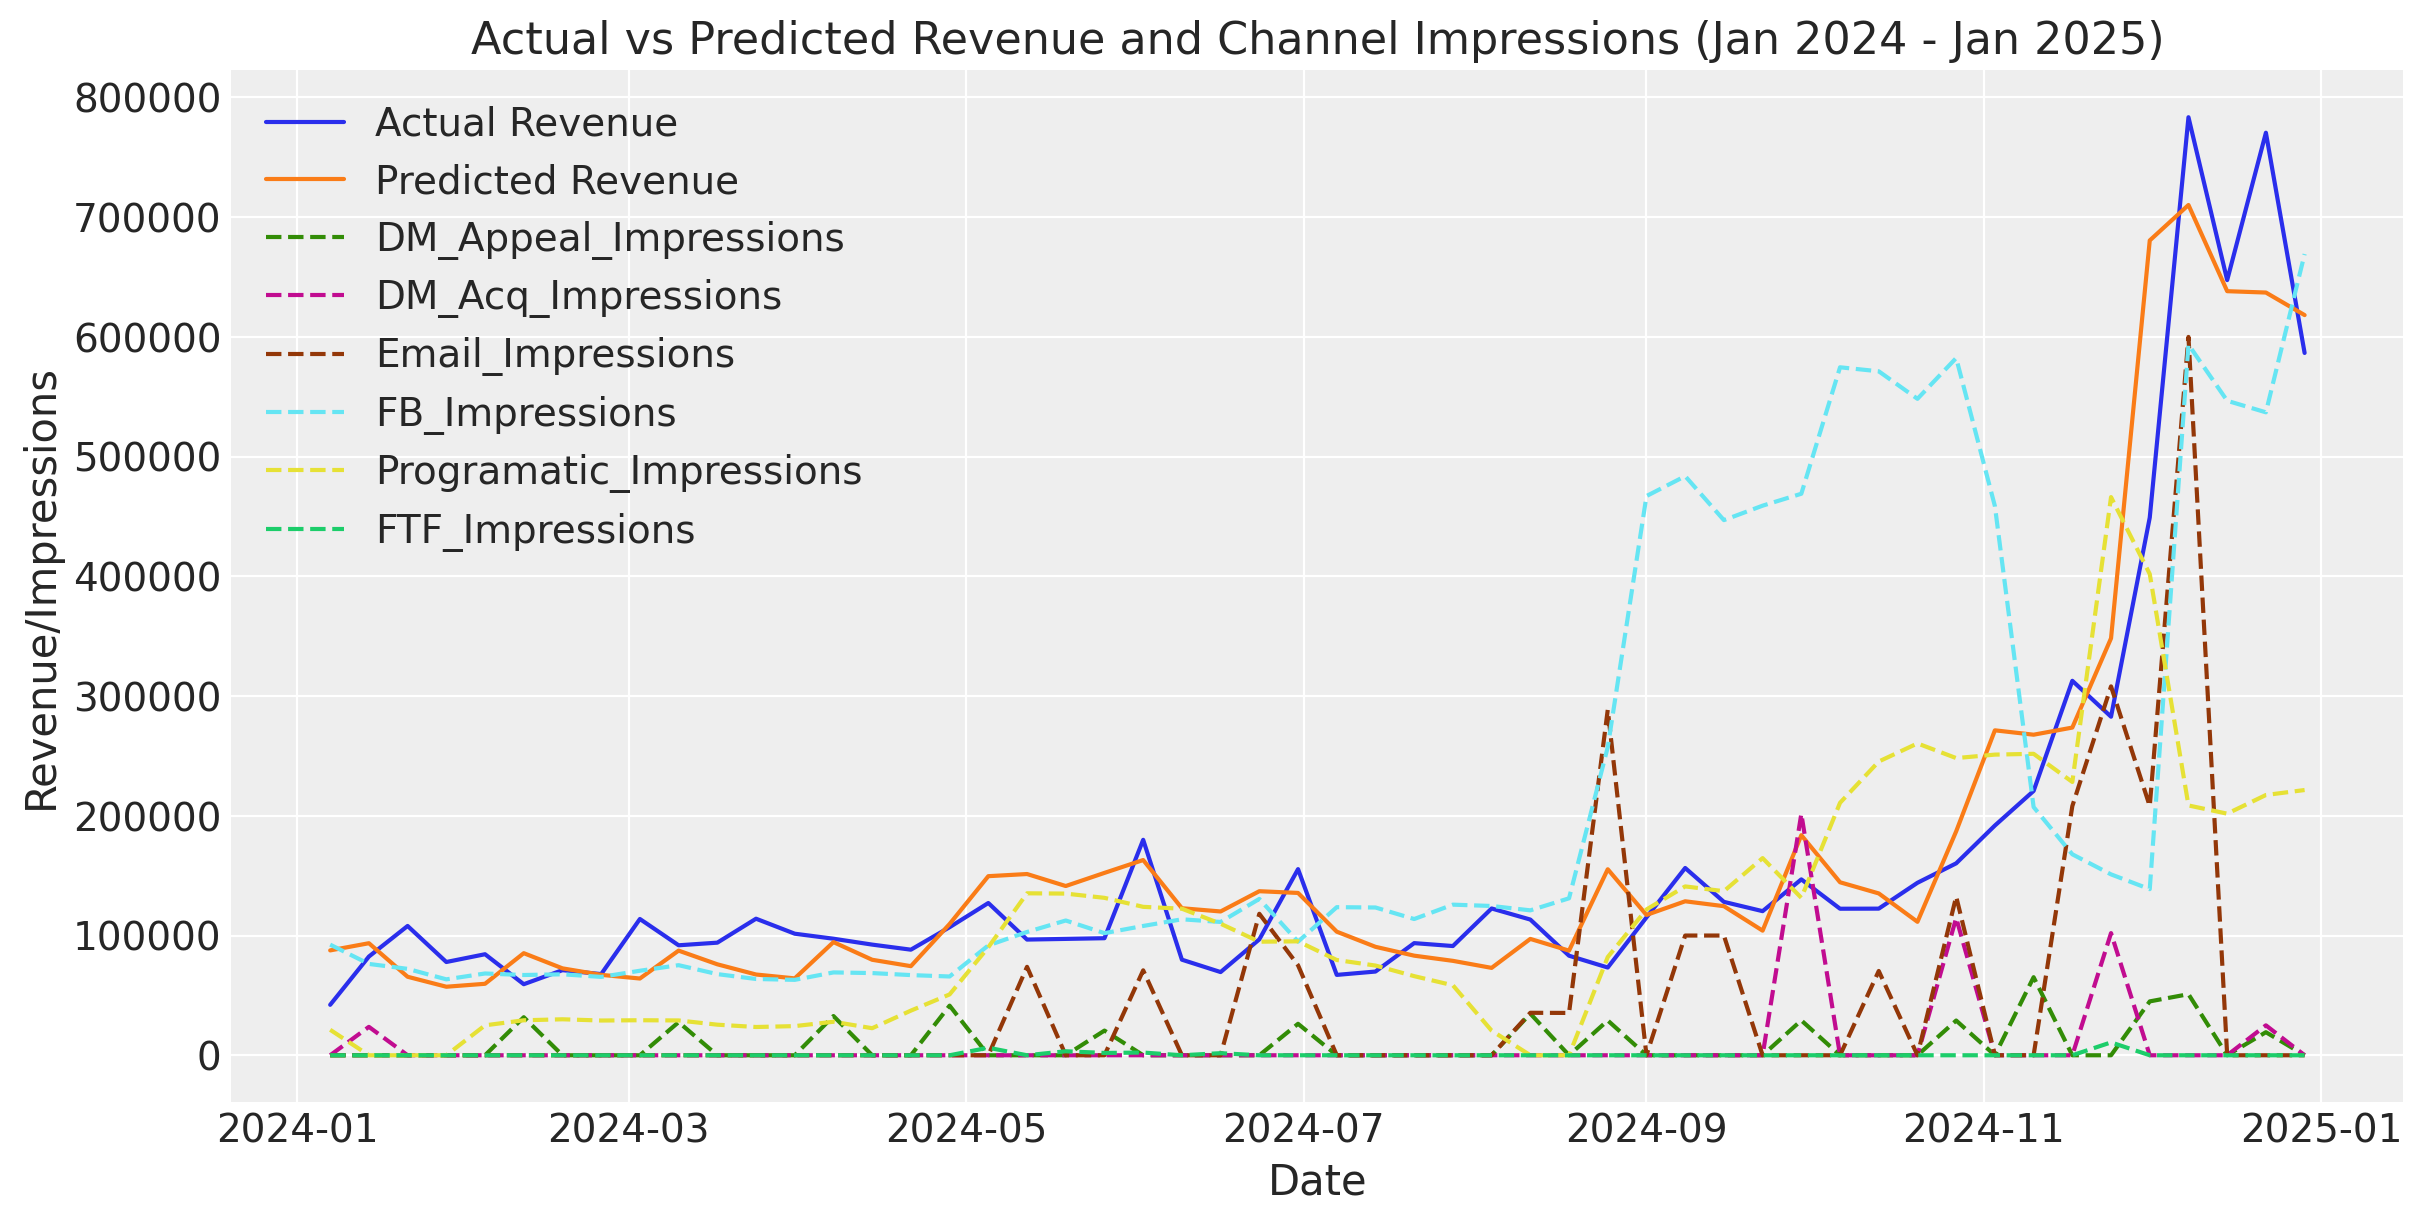

In [221]:
# prompt: # prompt: how do I access y and y_pred and plot them, I only want values for jan 2024 through jan 2025
# import pandas as pd
# import matplotlib.pyplot as plt
# y_pred = mmm.predict(X)
# # Filter for Jan 2024 to Jan 2025
# start_date = pd.to_datetime('2024-01-01')
# end_date = pd.to_datetime('2025-01-01')
# mask = (X['Date'] >= start_date) & (X['Date'] < end_date)
# y_filtered = y[mask]
# y_pred_filtered = y_pred[mask]
# for channel in ch:
#   plt.plot(X_test["Date"], X_test[channel], label=channel, linestyle="--")
# plt.figure(figsize=(12, 6))
# plt.plot(X['Date'][mask], y_filtered, label='Actual Revenue')
# plt.plot(X['Date'][mask], y_pred_filtered, label='Predicted Revenue')
# plt.xlabel('Date')
# plt.ylabel('Revenue')
# plt.title('Actual vs Predicted Revenue (Jan 2024 - Jan 2025)')
# plt.legend()
# plt.grid(True)
# plt.show()
# I'd like this on the same graph

import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have y and y_pred available from your code
# Filter for Jan 2024 to Jan 2025
start_date = pd.to_datetime('2024-01-01')
end_date = pd.to_datetime('2025-01-01')
mask = (X['Date'] >= start_date) & (X['Date'] < end_date)
y_filtered = y[mask]
y_pred_filtered = y_pred[mask]


plt.figure(figsize=(12, 6))
plt.plot(X['Date'][mask], y_filtered, label='Actual Revenue')
plt.plot(X['Date'][mask], y_pred_filtered, label='Predicted Revenue')

# Add the code for plotting channel impressions on the same graph
for channel in ch:
    plt.plot(X['Date'][mask], X[channel][mask], label=channel, linestyle="--")

plt.xlabel('Date')
plt.ylabel('Revenue/Impressions')
plt.title('Actual vs Predicted Revenue and Channel Impressions (Jan 2024 - Jan 2025)')
plt.legend()
plt.grid(True)
plt.show()


In [215]:

df_holdout = pd.DataFrame({
    "Date": X["Date"],
    "Actual Revenue": y,
    "Predicted Revenue": y_pred
})

# Set the Date as the DataFrame index to make plotting easier.
df_holdout.set_index("Date", inplace=True)

# Plot the Actual vs. Predicted Revenue over time.
plt.figure(figsize=(12, 6))
plt.plot(df_holdout.index, df_holdout["Actual Revenue"], label="Actual Revenue", marker="o")
plt.plot(df_holdout.index, df_holdout["Predicted Revenue"], label="Predicted Revenue", marker="x")

# Add impressions to the plot
for channel in ch:
  plt.plot(Xt["Date"], X[channel], label=channel, linestyle="--")

plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Holdout: Actual vs. Predicted Revenue")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


NameError: name 'y_pred' is not defined

#Q1 through Q3 2024

In [207]:

# 4) Split your data by time index
train_size = 105  # or however many weeks you want 146 for last quarter

X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]
X_test = X.iloc[train_size:train_size+39]
y_test = y.iloc[train_size:train_size+39]

In [208]:

mmm_q1_q3 = MMM(
    model_config=custom_config,
    sampler_config={"progressbar": True},
    date_column="Date",
    adstock=GeometricAdstock(l_max=8),
    saturation=MichaelisMentenSaturation(),
    channel_columns=ch,
    control_columns=controls,
    yearly_seasonality=2,
    time_varying_media=True,
    time_varying_intercept=False
)

In [209]:
mmm_q1_q3.fit(X=X_train, y=y_train, nuts_sampler="numpyro", target_accept=0.99, chains=4, draws=4000)


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

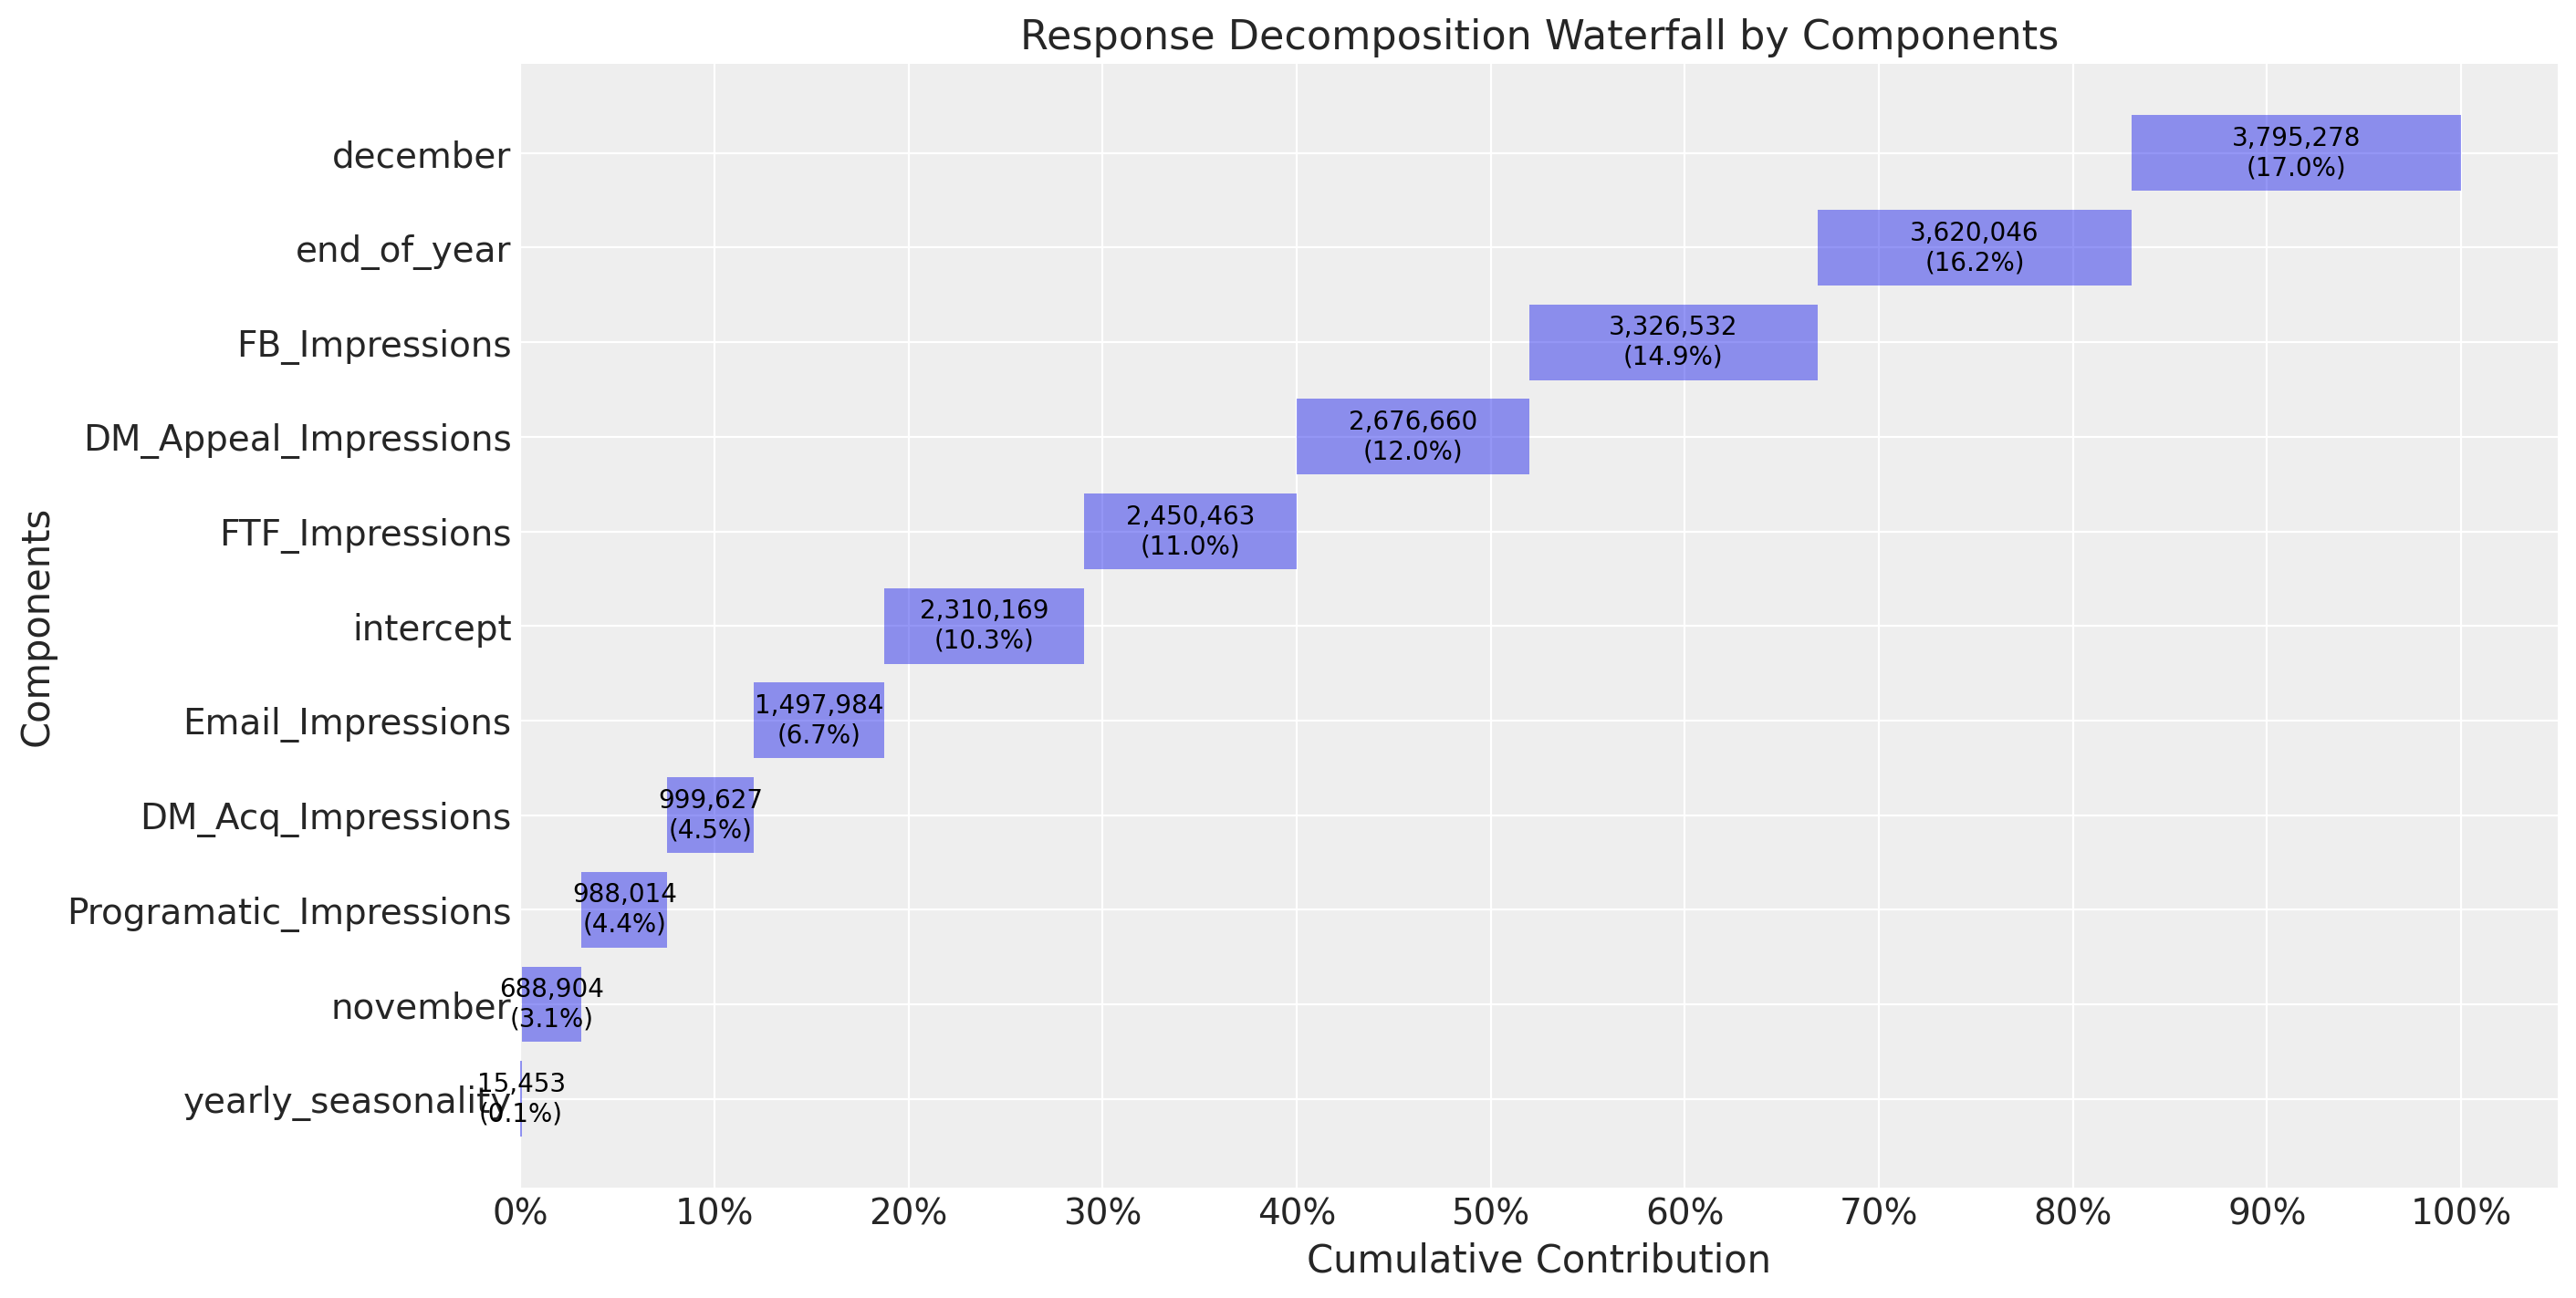

In [210]:
mmm_q1_q3.plot_waterfall_components_decomposition();

In [211]:
X_test['end_of_year'] = X_test['end_of_year'].astype(int)


<ipython-input-211-9dba4b162edf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['end_of_year'] = X_test['end_of_year'].astype(int)


In [212]:


import numpy as np
from sklearn.metrics import r2_score

y_pred_test = mmm_q1_q3.predict(X_test)

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred) # Convert to NumPy arrays if not already
    mask = y_true != 0  # Create a mask for non-zero values in y_true
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

print("Holdout R2:", r2_score(y_test, y_pred_test))
print("Holdout MAPE:", mape(y_test, y_pred_test), "%")


Output()

Holdout R2: -1.5992938884522996
Holdout MAPE: 40.09108479387442 %


<ipython-input-213-d5df56df93d7>:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


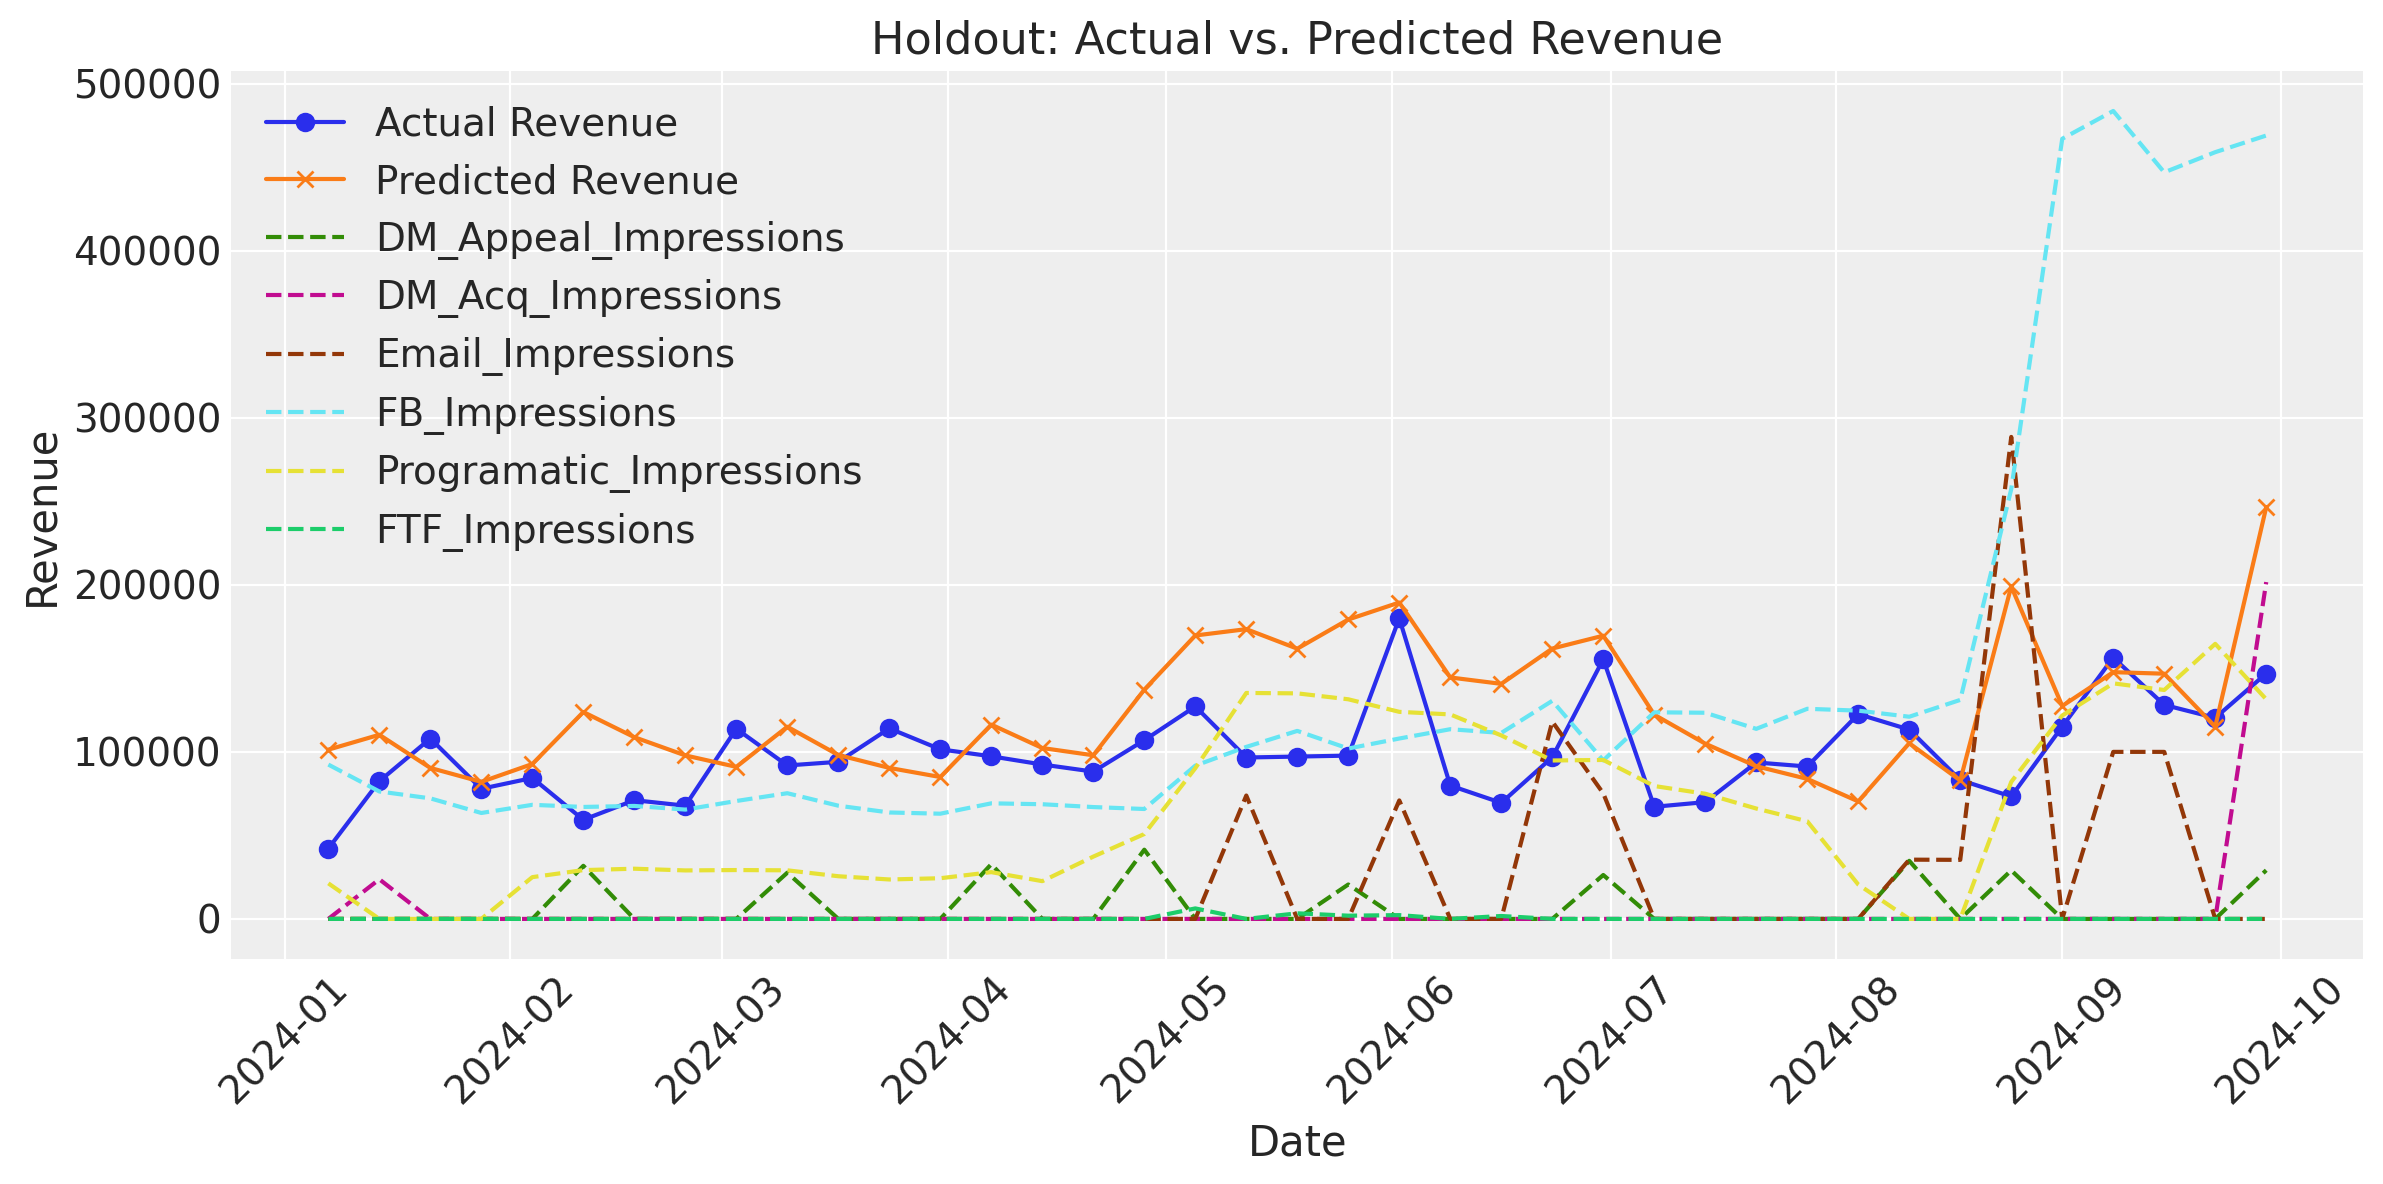

In [213]:
df_holdout = pd.DataFrame({
    "Date": X_test["Date"],
    "Actual Revenue": y_test,
    "Predicted Revenue": y_pred_test
})


df_holdout.set_index("Date", inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df_holdout.index, df_holdout["Actual Revenue"], label="Actual Revenue", marker="o")
plt.plot(df_holdout.index, df_holdout["Predicted Revenue"], label="Predicted Revenue", marker="x")

for channel in ch:
  plt.plot(X_test["Date"], X_test[channel], label=channel, linestyle="--")

plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Holdout: Actual vs. Predicted Revenue")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [214]:
stop

NameError: name 'stop' is not defined

# Q1 2024


In [ ]:

# 4) Split your data by time index
train_size = 105  # or however many weeks you want 146 for last quarter

X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]
X_test = X.iloc[train_size:train_size+13]
y_test = y.iloc[train_size:train_size+13]

In [ ]:
X_train

In [ ]:
X_test

In [ ]:

mmm_1 = MMM(
    model_config=custom_config,
    sampler_config={"progressbar": True},
    date_column="Date",
    adstock=GeometricAdstock(l_max=8),
    saturation=MichaelisMentenSaturation(),
    channel_columns=ch,
    control_columns=controls,
    yearly_seasonality=2,
    time_varying_media=True,
    time_varying_intercept=False
)

In [ ]:
# Fit the model on training data
mmm_1.fit(X=X_train, y=y_train, nuts_sampler="numpyro", target_accept=0.99, chains=4, draws=4000)






In [ ]:
mmm_1.plot_waterfall_components_decomposition();

In [ ]:
X_test['end_of_year'] = X_test['end_of_year'].astype(int)


In [ ]:


import numpy as np
from sklearn.metrics import r2_score

y_pred_test = mmm_1.predict(X_test)

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred) # Convert to NumPy arrays if not already
    mask = y_true != 0  # Create a mask for non-zero values in y_true
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

print("Holdout R2:", r2_score(y_test, y_pred_test))
print("Holdout MAPE:", mape(y_test, y_pred_test), "%")


In [ ]:
df_holdout = pd.DataFrame({
    "Date": X_test["Date"],
    "Actual Revenue": y_test,
    "Predicted Revenue": y_pred_test
})


df_holdout.set_index("Date", inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df_holdout.index, df_holdout["Actual Revenue"], label="Actual Revenue", marker="o")
plt.plot(df_holdout.index, df_holdout["Predicted Revenue"], label="Predicted Revenue", marker="x")

for channel in ch:
  plt.plot(X_test["Date"], X_test[channel], label=channel, linestyle="--")

plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Holdout: Actual vs. Predicted Revenue")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
#fixes boolean
X_test['end_of_year'] = X_test['end_of_year'].astype(int)




In [ ]:


import numpy as np
from sklearn.metrics import r2_score

y_pred_test = mmm.predict(X_test)

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred) # Convert to NumPy arrays if not already
    mask = y_true != 0  # Create a mask for non-zero values in y_true
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

print("Holdout R2:", r2_score(y_test, y_pred_test))
print("Holdout MAPE:", mape(y_test, y_pred_test), "%")


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df_holdout = pd.DataFrame({
    "Date": X_test["Date"],
    "Actual Revenue": y_test,
    "Predicted Revenue": y_pred_test
})

df_holdout.set_index("Date", inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df_holdout.index, df_holdout["Actual Revenue"], label="Actual Revenue", marker="o")
plt.plot(df_holdout.index, df_holdout["Predicted Revenue"], label="Predicted Revenue", marker="x")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Holdout: Actual vs. Predicted Revenue")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
df_holdout = pd.DataFrame({
    "Date": X_test["Date"],
    "Actual Revenue": y_test,
    "Predicted Revenue": y_pred_test
})


df_holdout.set_index("Date", inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df_holdout.index, df_holdout["Actual Revenue"], label="Actual Revenue", marker="o")
plt.plot(df_holdout.index, df_holdout["Predicted Revenue"], label="Predicted Revenue", marker="x")

for channel in ch:
  plt.plot(X_test["Date"], X_test[channel], label=channel, linestyle="--")

plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Holdout: Actual vs. Predicted Revenue")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Q2 2024

In [ ]:
mmm2 = MMM(
    model_config=custom_config,
    sampler_config={"progressbar": True},
    date_column="Date",
    adstock=GeometricAdstock(l_max=8),
    saturation=MichaelisMentenSaturation(),
    channel_columns=ch,
    control_columns=controls,
    yearly_seasonality=2,
    time_varying_media=True,
    time_varying_intercept=False
)

In [ ]:
train_size = 105+13  # or however many weeks you want 146 for last quarter

X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]
X_test = X.iloc[train_size:train_size+13]
y_test = y.iloc[train_size:train_size+13]

In [ ]:
X_train

In [ ]:
X_test

In [ ]:
# Fit the model on training data
mmm2.fit(X=X_train, y=y_train, nuts_sampler="numpyro", target_accept=0.99, chains=4, draws=4000)






In [ ]:
mmm.plot_waterfall_components_decomposition();

In [ ]:


import numpy as np
from sklearn.metrics import r2_score

y_pred_test = mmm2.predict(X_test) # This line is added to predict on the holdout set


# ... (your existing code) ...

# 6) Predict on the holdout
#    NOTE: We do NOT drop 'Date' from X_test. Keep the same columns as X_train.
def mape(y_true, y_pred):
    # Avoid division by zero
    y_true, y_pred = np.array(y_true), np.array(y_pred) # Convert to NumPy arrays if not already
    mask = y_true != 0  # Create a mask for non-zero values in y_true
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

print("Holdout R2:", r2_score(y_test, y_pred_test))
print("Holdout MAPE:", mape(y_test, y_pred_test), "%")


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume X_test is your test DataFrame and includes a "Date" column.
# y_test_lin and y_pred_test_lin are the true and predicted revenues on the original scale.
# For example:
# y_pred_test_lin = np.exp(y_pred_test) - 1
# y_test_lin = np.exp(y_test) - 1

# Create a DataFrame with Date, Actual, and Predicted values.
df_holdout = pd.DataFrame({
    "Date": X_test["Date"],
    "Actual Revenue": y_test,
    "Predicted Revenue": y_pred_test
})

# Set the Date as the DataFrame index to make plotting easier.
df_holdout.set_index("Date", inplace=True)

# Plot the Actual vs. Predicted Revenue over time.
plt.figure(figsize=(12, 6))
plt.plot(df_holdout.index, df_holdout["Actual Revenue"], label="Actual Revenue", marker="o")
plt.plot(df_holdout.index, df_holdout["Predicted Revenue"], label="Predicted Revenue", marker="x")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Holdout: Actual vs. Predicted Revenue")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:

df_holdout = pd.DataFrame({
    "Date": X_test["Date"],
    "Actual Revenue": y_test,
    "Predicted Revenue": y_pred_test
})

# Set the Date as the DataFrame index to make plotting easier.
df_holdout.set_index("Date", inplace=True)

# Plot the Actual vs. Predicted Revenue over time.
plt.figure(figsize=(12, 6))
plt.plot(df_holdout.index, df_holdout["Actual Revenue"], label="Actual Revenue", marker="o")
plt.plot(df_holdout.index, df_holdout["Predicted Revenue"], label="Predicted Revenue", marker="x")

# Add impressions to the plot
for channel in ch:
  plt.plot(X_test["Date"], X_test[channel], label=channel, linestyle="--")

plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Holdout: Actual vs. Predicted Revenue")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Q3 2024

In [ ]:

# 4) Split your data by time index
train_size = 105+13+13  # or however many weeks you want 146 for last quarter

X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]
X_test = X.iloc[train_size:train_size+13]
y_test = y.iloc[train_size:train_size+13]

In [ ]:
X_train

In [ ]:
X_test

In [ ]:
mmm3 = MMM(
    model_config=custom_config,
    sampler_config={"progressbar": True},
    date_column="Date",
    adstock=GeometricAdstock(l_max=8),
    saturation=MichaelisMentenSaturation(),
    channel_columns=ch,
    control_columns=controls,
    yearly_seasonality=2,
    time_varying_media=True,
    time_varying_intercept=False
)

In [ ]:
# Fit the model on training data
mmm3.fit(X=X_train, y=y_train, nuts_sampler="numpyro", target_accept=0.99, chains=4, draws=4000)


In [ ]:
mmm3.plot_waterfall_components_decomposition();

In [ ]:
X_test['end_of_year'] = X_test['end_of_year'].astype(int)


In [ ]:


import numpy as np
from sklearn.metrics import r2_score

y_pred_test = mmm2.predict(X_test) # This line is added to predict on the holdout set


def mape(y_true, y_pred):
    # Avoid division by zero
    y_true, y_pred = np.array(y_true), np.array(y_pred) # Convert to NumPy arrays if not already
    mask = y_true != 0  # Create a mask for non-zero values in y_true
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

print("Holdout R2:", r2_score(y_test, y_pred_test))
print("Holdout MAPE:", mape(y_test, y_pred_test), "%")


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume X_test is your test DataFrame and includes a "Date" column.
# y_test_lin and y_pred_test_lin are the true and predicted revenues on the original scale.
# For example:
# y_pred_test_lin = np.exp(y_pred_test) - 1
# y_test_lin = np.exp(y_test) - 1

# Create a DataFrame with Date, Actual, and Predicted values.
df_holdout = pd.DataFrame({
    "Date": X_test["Date"],
    "Actual Revenue": y_test,
    "Predicted Revenue": y_pred_test
})

# Set the Date as the DataFrame index to make plotting easier.
df_holdout.set_index("Date", inplace=True)

# Plot the Actual vs. Predicted Revenue over time.
plt.figure(figsize=(12, 6))
plt.plot(df_holdout.index, df_holdout["Actual Revenue"], label="Actual Revenue", marker="o")
plt.plot(df_holdout.index, df_holdout["Predicted Revenue"], label="Predicted Revenue", marker="x")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Holdout: Actual vs. Predicted Revenue")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# prompt: add impression to the actual vs predicted graph above

# ... (your existing code) ...

# Assume X_test is your test DataFrame and includes a "Date" column.
# y_test_lin and y_pred_test_lin are the true and predicted revenues on the original scale.
# For example:
# y_pred_test_lin = np.exp(y_pred_test) - 1
# y_test_lin = np.exp(y_test) - 1

# Create a DataFrame with Date, Actual, and Predicted values.
df_holdout = pd.DataFrame({
    "Date": X_test["Date"],
    "Actual Revenue": y_test,
    "Predicted Revenue": y_pred_test
})

# Set the Date as the DataFrame index to make plotting easier.
df_holdout.set_index("Date", inplace=True)

# Plot the Actual vs. Predicted Revenue over time.
plt.figure(figsize=(12, 6))
plt.plot(df_holdout.index, df_holdout["Actual Revenue"], label="Actual Revenue", marker="o")
plt.plot(df_holdout.index, df_holdout["Predicted Revenue"], label="Predicted Revenue", marker="x")

# Add impressions to the plot
for channel in ch:
  plt.plot(X_test["Date"], X_test[channel], label=channel, linestyle="--")

plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Holdout: Actual vs. Predicted Revenue")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Q4 2024

In [ ]:

train_size = 105+13+13+13  # or however many weeks you want 146 for last quarter

X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]
X_test = X.iloc[train_size:]
y_test = y.iloc[train_size:]

In [ ]:
X_train

In [ ]:
X_test

In [ ]:
mmm4 = MMM(
    model_config=custom_config,
    sampler_config={"progressbar": True},
    date_column="Date",
    adstock=GeometricAdstock(l_max=8),
    saturation=MichaelisMentenSaturation(),
    channel_columns=ch,
    control_columns=controls,
    yearly_seasonality=2,
    time_varying_media=True,
    time_varying_intercept=False
)

In [ ]:
# Fit the model on training data
mmm4.fit(X=X_train, y=y_train, nuts_sampler="numpyro", target_accept=0.99, chains=4, draws=4000)


In [ ]:
X_test

In [ ]:
mmm.plot_waterfall_components_decomposition();

In [ ]:

import numpy as np
from sklearn.metrics import r2_score

y_pred_test = mmm2.predict(X_test) # This line is added to predict on the holdout set


def mape(y_true, y_pred):
    # Avoid division by zero
    y_true, y_pred = np.array(y_true), np.array(y_pred) # Convert to NumPy arrays if not already
    mask = y_true != 0  # Create a mask for non-zero values in y_true
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

print("Holdout R2:", r2_score(y_test, y_pred_test))
print("Holdout MAPE:", mape(y_test, y_pred_test), "%")


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


# Create a DataFrame with Date, Actual, and Predicted values.
df_holdout = pd.DataFrame({
    "Date": X_test["Date"],
    "Actual Revenue": y_test,
    "Predicted Revenue": y_pred_test
})

# Set the Date as the DataFrame index to make plotting easier.
df_holdout.set_index("Date", inplace=True)

# Plot the Actual vs. Predicted Revenue over time.
plt.figure(figsize=(12, 6))
plt.plot(df_holdout.index, df_holdout["Actual Revenue"], label="Actual Revenue", marker="o")
plt.plot(df_holdout.index, df_holdout["Predicted Revenue"], label="Predicted Revenue", marker="x")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Holdout: Actual vs. Predicted Revenue")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:

df_holdout = pd.DataFrame({
    "Date": X_test["Date"],
    "Actual Revenue": y_test,
    "Predicted Revenue": y_pred_test
})

# Set the Date as the DataFrame index to make plotting easier.
df_holdout.set_index("Date", inplace=True)

# Plot the Actual vs. Predicted Revenue over time.
plt.figure(figsize=(12, 6))
plt.plot(df_holdout.index, df_holdout["Actual Revenue"], label="Actual Revenue", marker="o")
plt.plot(df_holdout.index, df_holdout["Predicted Revenue"], label="Predicted Revenue", marker="x")

# Add impressions to the plot
for channel in ch:
  plt.plot(X_test["Date"], X_test[channel], label=channel, linestyle="--")

plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Holdout: Actual vs. Predicted Revenue")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
